In [9]:
# fix this
import sys
sys.path.append("EasyOCR/")

import easyocr

import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from utils import evaluate_predictions
from tqdm.notebook import tqdm

import pickle

In [2]:
img_path = '/home/anastasia/DATA/AIArchitecture/HandWritingDescriptor/data/cyrillic-handwriting-dataset/test'
gt = pd.read_csv(f"{img_path}/labels.csv")
gt.head()

,filename,words
0,test1.png,осталось
1,test10.png,поле
2,test100.png,Оптическое
3,test1000.png,1 класса
4,test1001.png,г. Ульяновск


In [16]:
model_idx = 0
custom_model_path = '/home/anastasia/DATA/AIArchitecture/HandWritingDescriptor/text-recognition-research/model_dir'

reader = easyocr.Reader(['ru'], gpu=True,
                       user_network_directory=custom_model_path,
                       model_storage_directory=custom_model_path,
                       recog_network=f"model_{model_idx}") 

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [17]:
results = []
for i in tqdm(range(len(gt))):
    row =gt.iloc[i]
    img = np.array(Image.open(f"{img_path}/{row['filename']}"))
    result = reader.readtext(img)
    text = " ".join([r[1] for r in result])
    results += [text]
    
gt[f"predictions_{model_idx}"] = results

  0%|          | 0/1543 [00:00<?, ?it/s]

In [19]:
eval_output = evaluate_predictions(gt, ground_truth_col='words', prediction_col='predictions_0')
with open(f"eval_0.pkl", 'wb') as f:
    pickle.dump(result, f)

print(f"Avg WER: {eval_output['average_wer']*100:.1f}%, Avg CER: {eval_output['average_cer']*100:.1f}%")

Calculating metrics: 100%|██████████| 1543/1543 [00:00<00:00, 5819.09it/s]

Avg WER: 81.9%, Avg CER: 28.9%


In [20]:
eval_output = evaluate_predictions(gt, ground_truth_col='words', prediction_col='predictions_1')
with open(f"eval_1.pkl", 'wb') as f:
    pickle.dump(eval_output, f)

print(f"Avg WER: {eval_output['average_wer']*100:.1f}%, Avg CER: {eval_output['average_cer']*100:.1f}%")

Calculating metrics: 100%|██████████| 1543/1543 [00:00<00:00, 6054.05it/s]

Avg WER: 84.3%, Avg CER: 30.7%


/home/anastasia/venvs/ai_architecture/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


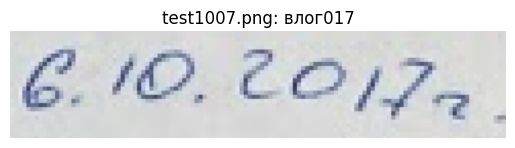

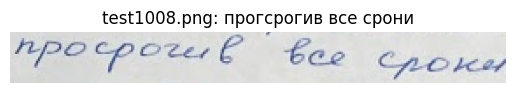

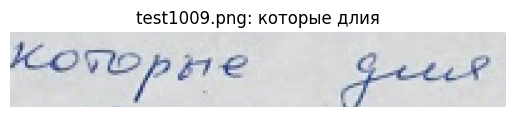

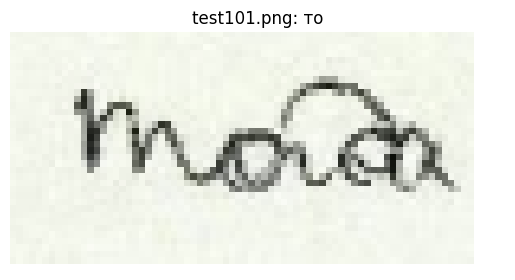

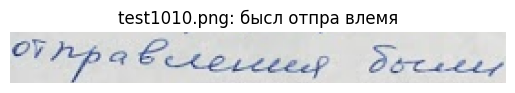

In [15]:
for i in range(10, 15):
    row =gt.iloc[i]
    img = np.array(Image.open(f"{img_path}/{row['filename']}"))
    result = reader.readtext(img)
    text = " ".join([r[1] for r in result])
    plt.imshow(img)
    plt.title(f"{row['filename']}: {text}")
    plt.axis('off')
    plt.show()


## print logs

In [5]:
import re
import matplotlib.pyplot as plt
import numpy as np

def parse_log_file(file_path):
    iterations = []
    current_accuracies = []
    current_norm_eds = []
    train_losses = []
    valid_losses = []
    
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
        
    # Split content into iteration blocks
    blocks = content.split('--------------------------------------------------------------------------------')
    
    for block in blocks:
        # Extract iteration number
        iter_match = re.search(r'\[(\d+)/\d+\]', block)
        if not iter_match:
            continue
            
        iteration = int(iter_match.group(1))
        
        # Extract losses
        loss_match = re.search(r'Train loss: (\d+\.\d+), Valid loss: (\d+\.\d+)', block)
        if loss_match:
            train_loss = float(loss_match.group(1))
            valid_loss = float(loss_match.group(2))
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
        
        # Extract current accuracy and norm_ED
        acc_match = re.search(r'Current_accuracy\s*:\s*(\d+\.\d+)', block)
        norm_ed_match = re.search(r'Current_norm_ED\s*:\s*(\d+\.\d+)', block)
        
        if acc_match and norm_ed_match:
            iterations.append(iteration)
            current_accuracies.append(float(acc_match.group(1)))
            current_norm_eds.append(float(norm_ed_match.group(1)))
    
    return iterations, current_accuracies, current_norm_eds, train_losses, valid_losses


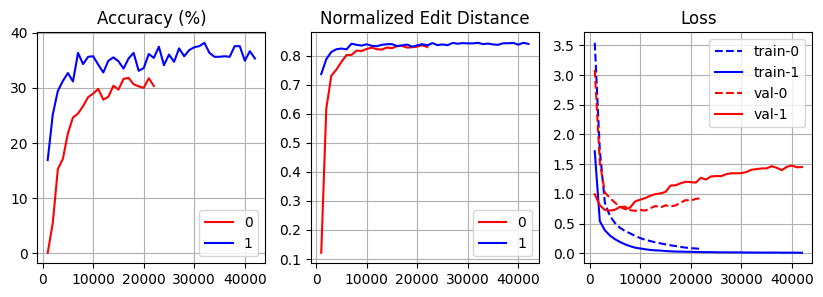

In [6]:
def plot_list(iters, metric, style='r-', label=None, ax=None):
    if ax is None: ax = plt.gca()
    ax.plot(iters, metric, style, label=label)
    ax.grid(True)

# Usage
file_path = 'EasyOCR/trainer/saved_models/cyrillic-v1/log_train.txt'

iterations_0, accuracies_0, norm_eds_0, train_losses_0, valid_losses_0 = \
    parse_log_file('EasyOCR/trainer/saved_models/cyrillic-v0-lr1/log_train.txt')

iterations_1, accuracies_1, norm_eds_1, train_losses_1, valid_losses_1 = \
    parse_log_file('EasyOCR/trainer/saved_models/cyrillic-v1/log_train.txt')

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].set_title("Accuracy (%)")
plot_list(iterations_0, accuracies_0, style='r', label='0', ax=axes[0])
plot_list(iterations_1, accuracies_1, style='b', label='1', ax=axes[0])
axes[0].legend()

axes[1].set_title("Normalized Edit Distance")
plot_list(iterations_0, norm_eds_0, style='r', label='0', ax=axes[1])
plot_list(iterations_1, norm_eds_1, style='b', label='1', ax=axes[1])
axes[1].legend()

axes[2].set_title("Loss")
plot_list(iterations_0, train_losses_0, style='b--', label="train-0", ax=axes[2])
plot_list(iterations_1, train_losses_1, style='b', label="train-1", ax=axes[2])

plot_list(iterations_0, valid_losses_0, style='r--', label="val-0", ax=axes[2])
plot_list(iterations_1, valid_losses_1, style='r', label="val-1", ax=axes[2])

axes[2].legend()

# plot_metrics(iterations, accuracies, norm_eds, train_losses, valid_losses)